# Project A: Classifying Sentiment from Text Reviews
In this project, our team will try to perfrom Bag of Word approch to implement sentiment clasificaion on product review on websites.

In [215]:
import os
import numpy as np
import pandas as pd
import random
import sklearn.linear_model
import sklearn.pipeline
import matplotlib
import matplotlib.pyplot as plt
import nltk
import tokenize_text
import cross_validation as cv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets, metrics, model_selection, svm
from nltk.corpus import stopwords
plt.style.use('seaborn-v0_8')

## Step1: Importing Dataset

In [187]:
# import datasets
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

# debug you
# printing out dataset
print(x_train_df)
print(x_test_df)
print(y_train_df)

     website_name                                               text
0          amazon  Oh and I forgot to also mention the weird colo...
1          amazon                       THAT one didn't work either.
2          amazon                                 Waste of 13 bucks.
3          amazon  Product is useless, since it does not have eno...
4          amazon  None of the three sizes they sent with the hea...
...           ...                                                ...
2395         yelp  The sweet potato fries were very good and seas...
2396         yelp  I could eat their bruschetta all day it is dev...
2397         yelp                               Ambience is perfect.
2398         yelp  We ordered the duck rare and it was pink and t...
2399         yelp       Service was good and the company was better!

[2400 rows x 2 columns]
    website_name                                               text
0         amazon  It only recognizes the Phone as its storage de...
1         a

In [188]:
# Print out the first five rows and last five rows
N, n_cols = x_train_df.shape
# print("Shape of x_train_df: (%d, %d)" % (N, n_cols))
# print("Shape of y_train_df: %s" % str(y_train_df.shape))

# Print out the first five rows and last five rows
tr_text_list = x_train_df['text'].values.tolist()

test_text_list = x_test_df['text'].values.tolist()

## Step2: Cleaning Imported Data and Count Vacabulary Friquency

In [189]:
# cleaning raw data
tok_count_dict = dict()
for line in tr_text_list:
    tok_list = tokenize_text.tokenize_text(line)
    for tok in tok_list:
        if tok in tok_count_dict:
            tok_count_dict[tok] += 1
        else:
            tok_count_dict[tok] = 1

In [190]:

# printing out the frequency of word
sorted_tokens = list(sorted(tok_count_dict, key=tok_count_dict.get, reverse=True))
# filter out words that only appear less than 4 times
vocab_list = [w for w in sorted_tokens if tok_count_dict[w] >= 4]

for w in vocab_list:
    print("%5d %s" % (tok_count_dict[w], w))

 1560 the
  916 and
  707 a
  700 i
  609 is
  542 to
  534 it
  493 of
  493 this
  447 was
  328 in
  267 
  257 for
  244 not
  231 that
  212 with
  202 my
  202 very
  184 good
  176 on
  163 you
  162 great
  158 but
  147 have
  143 are
  142 so
  140 movie
  137 phone
  136 as
  120 film
  116 be
  115 all
  111 one
  111 its
  109 had
  103 at
  100 place
   98 food
   95 like
   94 were
   90 an
   89 just
   86 there
   84 service
   84 time
   83 if
   82 we
   79 bad
   79 really
   78 out
   76 they
   76 from
   75 would
   71 well
   69 has
   69 about
   66 your
   65 dont
   64 only
   63 even
   63 ever
   63 best
   62 by
   62 back
   62 or
   59 here
   57 also
   57 will
   56 no
   54 up
   53 go
   52 than
   51 quality
   51 when
   51 love
   50 me
   50 what
   49 can
   49 he
   48 made
   48 more
   47 product
   47 because
   47 excellent
   45 im
   45 better
   45 which
   44 recommend
   44 some
   42 work
   42 could
   42 ive
   42 get
   42 too
   4

## Step3: Feature Extration

In [191]:
sorted_tokens = list(sorted(tok_count_dict, key=tok_count_dict.get, reverse=True))

# filter out the vocabulary that appears in just one time
vocab_list_2 = [w for w in sorted_tokens if tok_count_dict[w] >= 1]

# for first attempt, we tried to manualy built vocabulary list
vocab_list = ['good', 'great', 'like', 'bad', 'best', 'love', 'excellent', 'better', 'recommend',
              'nice', 'disappointed', 'pretty', 'worst', 'waste', 'amazing', 'terrible', 'wonderful',
              'poor', 'friendly', 'loved', 'delicious', 'horrible', 'cool', 'happy', 'awesome', 'awful',
              'stupid', 'perfect', 'impressed', 'comfortable', 'fantastic', 'beautiful', 'interesting',
              'perfectly', 'disappointing', 'super', 'fast', 'problem', 'bland', 'worse', 'enjoyed', 'fresh',
              'avoid', 'incredible', 'didn\'t work', 'weird', 'useless', 'enjoy',
              'sucked', 'disappointment', 'unfortunately', 'mediocre', 'recommended', 'pleased', 'junk']

# for second try, we tried to import stopword from Natural Language Tool Kit
nltk.download('stopwords')
useless = stopwords.words('english')
filtered_words = [word for word in vocab_list_2 if not word in useless]

# print out sizes
print("The size of the original vacabulary list:")
print(len(sorted_tokens))

print("The size of the first vacabulary list:")
print(len(vocab_list))

print("The size of the second vacabulary list:")
print(len(filtered_words))

vocab_dict = dict()

for vocab_id, tok in enumerate(filtered_words):
    vocab_dict[tok] = vocab_id

The size of the original vacabulary list:
4747
The size of the first vacabulary list:
55
The size of the second vacabulary list:
4624


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\globa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [192]:
bow_preprocessor = CountVectorizer(binary=False, vocabulary=vocab_dict)

bow_preprocessor.fit(tr_text_list)

sparse_arr = bow_preprocessor.transform(tr_text_list)

print(sparse_arr.shape)

dense_arr_NV = sparse_arr.toarray()

print(dense_arr_NV.shape)

(2400, 4624)
(2400, 4624)


## Step4: Create Pipelines

In [193]:
my_bow_classifier_pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor',
     CountVectorizer(min_df=1, max_df=1.0, ngram_range=(1, 1), vocabulary=vocab_dict, binary=False)),
    ('my_classifier', sklearn.linear_model.LogisticRegression(C=1.0, max_iter=1000, random_state=101))
])

my_parameter_grid_by_name = dict()
my_parameter_grid_by_name['my_bow_feature_extractor__min_df'] = [1, 2, 4]
my_parameter_grid_by_name['my_classifier__C'] = np.logspace(-5, 5, 11)

my_scoring_metric_name = 'accuracy'
y_true = np.ravel(y_train_df)
# print(y_true)

## Step5: Cross Validation

In [197]:
prng = np.random.RandomState(0)

valid_ids = prng.choice(np.arange(N), size=800)

valid_indicators_N = np.zeros(N)
valid_indicators_N[valid_ids] = -1

my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_N)

grid_searcher = sklearn.model_selection.GridSearchCV(
    my_bow_classifier_pipeline,
    my_parameter_grid_by_name,
    scoring=my_scoring_metric_name,
    cv=my_splitter,
    refit=False)

grid_searcher.fit(tr_text_list, y_true)

gsearch_results_df = pd.DataFrame(grid_searcher.cv_results_).copy()

param_keys = ['param_my_bow_feature_extractor__min_df', 'param_my_classifier__C']

# Rearrange row order so it is easy to skim
gsearch_results_df.sort_values(param_keys, inplace=True)

var = gsearch_results_df[param_keys + ['split0_test_score', 'rank_test_score']]

print(var)

# y_test_pred = np.ravel(test_text_list)
# my_bow_classifier_pipeline.fit(tr_text_list, y_true)
# result = my_bow_classifier_pipeline.predict(y_test_pred)
#
# print(result[:, np.newaxis])


# print(yhat_tr_N[:,np.newaxis])

   param_my_bow_feature_extractor__min_df param_my_classifier__C  \
0                                       1                0.00001   
1                                       1                 0.0001   
2                                       1                  0.001   
3                                       1                   0.01   
4                                       1                    0.1   
5                                       1                    1.0   
6                                       1                   10.0   
7                                       1                  100.0   
8                                       1                 1000.0   
9                                       1                10000.0   
10                                      1               100000.0   
11                                      2                0.00001   
12                                      2                 0.0001   
13                                      2       

In [230]:
# Ju-Hung's attempt
train_ids, test_ids = cv.make_train_and_test_row_ids_for_n_fold_cv(len(y_true), random_state=8964)
x_tr, y_tr = list(), list()
x_va, y_va = list(), list()

for index in train_ids[0]:
    x_tr.append(tr_text_list[index])
    y_tr.append(y_true[index])

for index in test_ids[0]:
    x_va.append(tr_text_list[index])
    y_va.append(y_true[index])
    
ju_grid_searcher = sklearn.model_selection.GridSearchCV(
    my_bow_classifier_pipeline,
    my_parameter_grid_by_name,
    scoring=my_scoring_metric_name,
    refit=False)
ju_grid_searcher.fit(x_tr, y_tr)
gsearch_results_df = pd.DataFrame(ju_grid_searcher.cv_results_).copy()

param_keys = ['param_my_bow_feature_extractor__min_df', 'param_my_classifier__C']

# Rearrange row order so it is easy to skim
gsearch_results_df.sort_values(param_keys, inplace=True)

var = gsearch_results_df[param_keys + ['split0_test_score', 'rank_test_score']]

print(var)

   param_my_bow_feature_extractor__min_df param_my_classifier__C  \
0                                       1                0.00001   
1                                       1                 0.0001   
2                                       1                  0.001   
3                                       1                   0.01   
4                                       1                    0.1   
5                                       1                    1.0   
6                                       1                   10.0   
7                                       1                  100.0   
8                                       1                 1000.0   
9                                       1                10000.0   
10                                      1               100000.0   
11                                      2                0.00001   
12                                      2                 0.0001   
13                                      2       

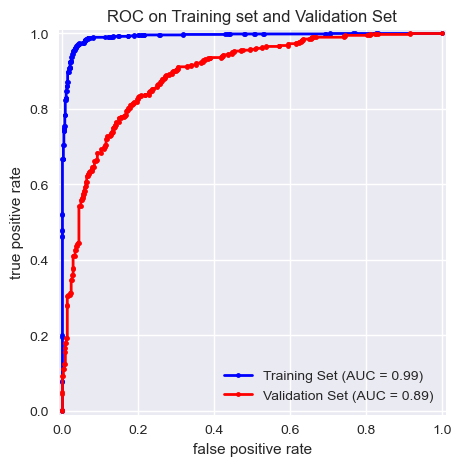

In [241]:
best_train_pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(min_df=1, max_df=1.0, ngram_range=(1, 1), vocabulary=vocab_dict, binary=False)),
    ('my_classifier', sklearn.linear_model.LogisticRegression(C=1.0, max_iter=1000, random_state=101))
])

best_train_pipeline.fit(x_tr, y_tr)
yhat_tr_N = best_train_pipeline.predict_proba(x_tr)
yhat_va_N = best_train_pipeline.predict_proba(x_va)
plt.subplots(nrows=1, ncols=1, figsize=(5,5));
fpr_tr, tpr_tr, th = sklearn.metrics.roc_curve(y_tr, yhat_tr_N[:, 1])
fpr_va, tpr_va, th = sklearn.metrics.roc_curve(y_va, yhat_va_N[:, 1])
roc_auc_tr = sklearn.metrics.auc(fpr_tr, tpr_tr)
roc_auc_va = sklearn.metrics.auc(fpr_va, tpr_va)

plt.plot(fpr_tr, tpr_tr, '.-', color='b', lw=2, label=f'Training Set (AUC = {roc_auc_tr:.2f})')
plt.plot(fpr_va, tpr_va, '.-', color='r', lw=2, label=f'Validation Set (AUC = {roc_auc_va:.2f})')

plt.title("ROC on Training set and Validation Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01

plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

## Step6: Hyperparameter Selection for Logistic Regression Classifier

In [202]:
def calc_ACC(ytrue_N, yhat_N):
    # calling calculating function from above
    TP, TN, FP, FN = calc_TP_TN_FP_FN(ytrue_N, yhat_N)
    # defining denominator
    de = TP + TN + FP + FN + 1e-10
    # calculating accuracy
    acc = (TP + TN) / de
    return acc  # TODO fix me

def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    # Cast input to integer just to be sure we're getting what's expected
    ytrue_N = np.asarray(ytrue_N, dtype=np.int32)
    yhat_N = np.asarray(yhat_N, dtype=np.int32)

    # TODO fix by calculating the number of true pos, true neg, etc.
    TP = np.sum((ytrue_N == 1) & (yhat_N == 1))
    TN = np.sum((ytrue_N == 0) & (yhat_N == 0))
    FP = np.sum((ytrue_N == 0) & (yhat_N == 1))
    FN = np.sum((ytrue_N == 1) & (yhat_N == 0))

    # debug you
    # print(TP, TN, FP, FN)
    return TP.item(), TN.item(), FP.item(), FN.item() 

Acc of best pipe:
0.963


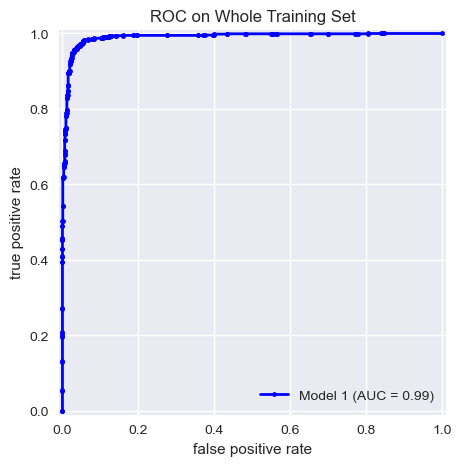

In [210]:
best_train_pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(min_df=1, max_df=1.0, ngram_range=(1, 1), vocabulary=vocab_dict, binary=False)),
    ('my_classifier', sklearn.linear_model.LogisticRegression(C=1.0, max_iter=1000, random_state=101))
])

best_train_pipeline.fit(tr_text_list, y_true)
yhat_tr_N = best_train_pipeline.predict(tr_text_list)

acc = np.round(calc_ACC(y_true, yhat_tr_N), 3)
print("Acc of best pipe:")
print(acc)

yhat_tr_N = best_train_pipeline.predict_proba(tr_text_list)
plt.subplots(nrows=1, ncols=1, figsize=(5,5));
fpr, tpr, th = sklearn.metrics.roc_curve(y_true, yhat_tr_N[:, 1])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, '.-', color='b', lw=2, label=f'Model 1 (AUC = {roc_auc:.2f})')

plt.title("ROC on Whole Training Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01

plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

In [ ]:
best_train_pipeline.fit(tr_text_list, y_true)

my_valid_text_list = [tr_text_list[index] for index in valid_ids]
print(my_valid_text_list)
my_valid_true_list = [y_true[index] for index in valid_ids]
print(my_valid_true_list)

## Step7: Using the Best Pipeline to Predict the Result

In [11]:
new_pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(min_df=1, max_df=1.0, ngram_range=(1, 1), vocabulary=vocab_dict, binary=False)),
    ('my_classifier', sklearn.linear_model.LogisticRegression(C=1.0, max_iter=1000, random_state=101))
])

new_pipeline.fit(tr_text_list, y_true)
yhat_tr_N = new_pipeline.predict(tr_text_list)
acc = np.mean(y_true == yhat_tr_N)
print(acc)

yhat_test_N = new_pipeline.predict_proba(test_text_list)


float_y_test = yhat_test_N[:,1]

print(float_y_test)

print(float_y_test.T)

0.9633333333333334
[0.62046604 0.49903021 0.04047966 0.08190969 0.43429751 0.234294
 0.18919695 0.21753659 0.45236634 0.48948749 0.4700432  0.49955902
 0.06463395 0.23095775 0.12391673 0.22585905 0.01162406 0.12602387
 0.30966111 0.46967848 0.32798882 0.80272303 0.34660883 0.63941181
 0.18564912 0.28927044 0.11235399 0.41253816 0.30881727 0.3745664
 0.33458067 0.37084583 0.28866148 0.18097874 0.41667162 0.48652297
 0.46844879 0.35120818 0.79960855 0.40198479 0.08896942 0.16334475
 0.70490411 0.14884563 0.49443342 0.20377364 0.54471988 0.2071105
 0.01179928 0.30881727 0.12302065 0.15074044 0.82526901 0.74134253
 0.29940647 0.25322137 0.14530045 0.03339261 0.64687824 0.04808236
 0.13735325 0.29121088 0.12302065 0.08154496 0.32084553 0.0559571
 0.20669286 0.89681185 0.19807693 0.56812119 0.24807235 0.41253816
 0.15531084 0.02881026 0.32828654 0.30416875 0.2614436  0.04929479
 0.35029235 0.73891079 0.22875678 0.12596727 0.26281469 0.15810331
 0.01001209 0.20426154 0.1681406  0.16586347 0.1

In [56]:
import numpy as np
import pandas as pd
import sklearn.metrics

def calc_confusion_matrix_for_probas_and_threshold(ytrue_N, yproba1_N, thr):
    ytrue_N = np.asarray(ytrue_N, dtype=np.int32)
    
    # Determine hard predictions given probabilities
    yproba1_N = np.asarray(yproba1_N, dtype=np.float64)
    yhat_N = np.asarray(yproba1_N >= thr, dtype=np.int32)

    cm = sklearn.metrics.confusion_matrix(ytrue_N, yhat_N)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [91]:
print(calc_confusion_matrix_for_probas_and_threshold(y_train_df, yhat_tr_N, 0.5))

Predicted     0     1
True                 
0          1164    36
1            51  1149


In [165]:
FP = list(np.where((yhat_tr_N == 1) & (y_true == 0))[0])
FN = list(np.where((yhat_tr_N == 0) & (y_true == 1))[0])

# debug you
# print(yhat_tr_N)
# print(y_true)
# print(len(yhat_tr_N), len(y_true))
# print(FP)
# print(FN)
FP_list = list()
FN_list = list()

rand_examples_FP = random.sample(FP, 10)
rand_examples_FN = random.sample(FN, 10)
# print(rand_5_examples_FP)


for index in rand_examples_FP:
    result = x_train_df['website_name'][index], x_train_df['text'][index]
    FP_list.append(result)
    
for index in rand_examples_FN:
    result = x_train_df['website_name'][index], x_train_df['text'][index]
    FN_list.append(result)
    
print("False Positive Examples:")
for row in FP_list:
    print('\t'.join(row))
    
print()
print("False Nagetive Examples:")
for row in FN_list:
    print('\t'.join(row))


False Positive Examples:
yelp	So don't go there if you are looking for good food...
yelp	The service here is fair at best.
imdb	And, quite honestly, often its not very good.  
imdb	Graphics is far from the best part of the game.  
yelp	I give it 2 thumbs down
yelp	Would not recommend to others.
amazon	If you plan to use this in a car forget about it.
amazon	I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good
yelp	I do love sushi, but I found Kabuki to be over-priced, over-hip and under-services.
imdb	Why was this film made?  

False Nagetive Examples:
imdb	Go rent it.  
amazon	Would recommend this item.
yelp	It is worth the drive.
yelp	I *heart* this place.
imdb	GO AND SEE IT!  
amazon	Battery charge-life is quite long.
imdb	10/10  
amazon	It is so small and you don't even realize that it is there after a while of getting used to it.
yelp	For sushi on the Strip, this is the place to go.
yelp	This was my first time and I can't wait until t